# Raven Healthcare

### Problem Statement

The raw data has to be preprocessed

# COVID-19 Data

### Data Dictionary

- __agebracket__:This provides the age of the case. This is applicable only for rows that represent individual records.
- __backupnotes__:This was used during initial days to record additional information. The usage of this has been discontinued.
- __contractedfromwhichpatientsuspected__: This field gives the patient id from whom the current patient is believed to have contracted the virus. This is based on state bulletins. As of July 10th, this field is used only for Karnataka records.
- __currentstatus__:This can have: Hospitalized, Recovered, Deceased or Migrated_Others as values. These represent the status of the case. Migrated_Others is used as a place holder for those cases that are marked by states as having migrated to other states or have died due to non covid reasons.
- __dateannounced__: This field gives the date on which the case(s) was reported by the state/central bulletin
- __detectedcity__: This field gives the city where the case(s) were reported.
- __detecteddistrict__: This field gives the district where the case(s) were reported.
- __detectedstate__: This field gives the state where the case(s) were reported.
- __estimatedonsetdate__: This field is not used.gender This provides the gender of the case. This is applicable only for rows that represent individual records.
- __nationality__: This provides the nationality of the case. This is applicable only for rows that represent individual records.
- __notes__: This provides the any notes regarding the case(s) that are reported.
- __numcases__: This field can any integer value. This field denotes the following:
    - If the value is == 1 : The row indicates an individual record (age and gender info are subject to state bulletin releases).
    - If the value != 1 (greater than or less than 1) : The row indicates a district level record.
    - If the value > 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added without district details as state bulletin did not have district details at the point of data entry.
    - If the value < 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added to adjust a previously added bulk entry as stated above
    - If the value < 0 and (detecteddistrict != '' and detecteddistrict != 'Unknown') : The row added due to state bulletins providing a reduced count for that district/day/category combination.
    - If the value == 0 : Ingore the record. This would've been an entry made and ignored later due to clarifications from state bulletins.
- __patientnumber__:This field used to hold a global patient number for all patients being reported. This has been discontinued with the shift to district level entries.
- __source1__:Source for the current row.
- __source2__:Additional source for the current row.
- __source3__:Additional source for the current row.
- __statecode__:A two letter code to represent the state/UT.
- __statepatientnumber__:A field to represent the state patient number if the state bulletin provided a state patient number.
- __statuschangedate__:A field to represent the change of status of patients from Hospitalized -> Recovered or Hospitalized -> Deceased. This field has been discontiuned with district level records.

The data is collected from data.gov.in and is available in different files. The first task is to merge all the data into a single file. 

### Importing Libraries

In [172]:
import os
import os.path
import sys
import pandas as pd
import numpy as np

## Data Acquisition

### Fetching Data

We have to acquire the latest data possible. So, we will be using BeautifulSoup for this:

In [173]:
# Please wait while the library is installed
!pip install tqdm --quiet --disable-pip-version-check

In [174]:
import re
import requests as rq
from bs4 import BeautifulSoup
from tqdm import tqdm

In [175]:
# Sending request to the website
res=rq.get('https://api.covid19india.org/documentation/csv/')

In [176]:
# Creating the soup object
soup=BeautifulSoup(res.content) 

In [177]:
# finding all the hyperlinks in the page
links=soup.find_all('a')

In [178]:
# Filtering the hyperlinks with only raw_data
final=[]
for i in links:
    temp=re.search('raw_data[\d*]+.\w+',i.text)
    if temp!=None:
        final.append(i)

In [179]:
# Check if raw_data folder exists or not. If not create a new folder
current_directory=os.getcwd() # Current working directory
if os.path.exists(current_directory+'/raw_data')==False:
    os.mkdir(current_directory+'/raw_data')

In [180]:
file_path=current_directory+'\\raw_data\\'

In [181]:
#### Fetching the raw data files (This take a while if you don't have any files downloaded already)
for i in final:
    res = rq.get(i.text, stream=True)
    res.raise_for_status()
    filename=i.text.split('latest/')[1]
    file_existence = os.path.isfile(file_path+'/'+filename)

    if file_existence!=True: # file does not exists
        with open(file_path+filename, 'wb+') as fd:
            with tqdm(
                unit='B', unit_scale=True,
                desc=str(res.status_code)+' | '+filename, total=int(res.headers.get('content-length', 0))
            ) as pbar:
                for chunk in res.iter_content(chunk_size=4096):
                    fd.write(chunk)
                    pbar.update(len(chunk))
    else:
        sys.stderr.write('File already exists: '+filename+'\n')

200 | raw_data1.csv: 2.88MB [00:00, 27.9MB/s]                  
200 | raw_data2.csv: 1.58MB [00:00, 27.4MB/s]                   
200 | raw_data3.csv: 1.56MB [00:00, 14.1MB/s]                  
200 | raw_data4.csv: 2.86MB [00:00, 22.3MB/s]                  
200 | raw_data5.csv: 3.09MB [00:00, 21.4MB/s]                  
200 | raw_data6.csv: 3.33MB [00:00, 21.9MB/s]                  
200 | raw_data7.csv: 3.09MB [00:00, 24.9MB/s]                  
200 | raw_data8.csv: 3.26MB [00:00, 28.0MB/s]                  
200 | raw_data9.csv: 3.92MB [00:00, 17.0MB/s]                  
200 | raw_data10.csv: 3.36MB [00:00, 26.0MB/s]                  
200 | raw_data11.csv: 4.12MB [00:00, 33.5MB/s]                  
200 | raw_data12.csv: 2.96MB [00:00, 20.2MB/s]                  
200 | raw_data13.csv: 3.22MB [00:00, 22.7MB/s]                  
200 | raw_data14.csv: 3.60MB [00:00, 22.1MB/s]                  
200 | raw_data15.csv: 3.40MB [00:00, 18.3MB/s]                  
200 | raw_data16.csv: 3.40MB [00:

### Merging Files

Before we merge all the files we have to see the data is consistent or not.

In [182]:
with os.scandir(file_path) as entries:
    summary={'file_name':[],'num_cols':[],'col_names':[]}
    for entry in entries:
        if str(entry.name).split('.')[1]=='csv':
            df=pd.read_csv(file_path+entry.name)
            summary['file_name'].append(entry.name)
            summary['num_cols'].append(len(df.columns))
            summary['col_names'].append(list(df.columns))
    pd.DataFrame(summary).to_csv('summary.csv',index=False)

In [183]:
su_df=pd.read_csv('summary.csv')
su_df

,file_name,num_cols,col_names
0,raw_data1.csv,21,"['Patient Number', 'State Patient Number', 'Da..."
1,raw_data10.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
2,raw_data11.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
3,raw_data12.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
4,raw_data13.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
5,raw_data14.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
6,raw_data15.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
7,raw_data16.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
8,raw_data17.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."
9,raw_data18.csv,20,"['Entry_ID', 'State Patient Number', 'Date Ann..."


The data collected seems to have some irregularities. The number of features(columns) recorded are not similar. 

#### Consistency Check

In [184]:
rdata1=pd.read_csv(file_path+'raw_data1.csv')
rdata2=pd.read_csv(file_path+'raw_data2.csv')
rdata3=pd.read_csv(file_path+'raw_data3.csv')

In [185]:
rdata1l=list(rdata1.columns)
rdata3l=list(rdata3.columns)

#### Finding the Difference in Features 

In [186]:
set(rdata1l).difference(set(rdata3l))

{'Backup Notes', 'Estimated Onset Date'}

In [187]:
set(rdata3l).difference(set(rdata1l))

{'Entry_ID'}

In [188]:
set(rdata3l).union(set(rdata1l))-set(rdata3l).intersection(set(rdata1l))

{'Backup Notes', 'Entry_ID', 'Estimated Onset Date'}

##### Data has 3 columns that are not properly available.

- Dropping  ```{'Backup Notes', 'Estimated Onset Date'}```
- We have to create ```Entry_ID``` for first two datasets

In [189]:
rdata1['Entry_ID']=rdata1.index
rdata2['Entry_ID']=np.array(rdata2.index)+rdata1.shape[0]

In [190]:
rdata1.drop(['Backup Notes','Estimated Onset Date'],axis=1,inplace=True)
rdata2.drop(['Backup Notes','Estimated Onset Date'],axis=1,inplace=True)

In [191]:
rdata1.to_csv(file_path+'raw_data1.csv',index=False)
rdata2.to_csv(file_path+'raw_data2.csv',index=False)

#### Merging Files

In [192]:
with os.scandir(file_path) as entries:
    final=pd.DataFrame()
    total=0
    for entry in entries:
        df=pd.read_csv(file_path+entry.name)
        final=final.append(df,ignore_index=True)
        sys.stdout.write('>>>>Done: '+str(entry.name)+' shape:'+str(df.shape)+'\n')
        total+=df.shape[0]
    final.to_csv('AllData.csv',index=False)

>>>>Done: raw_data1.csv shape:(17364, 20)
>>>>Done: raw_data10.csv shape:(23110, 20)
>>>>Done: raw_data11.csv shape:(29045, 20)
>>>>Done: raw_data12.csv shape:(22334, 20)
>>>>Done: raw_data13.csv shape:(24247, 20)
>>>>Done: raw_data14.csv shape:(27582, 20)
>>>>Done: raw_data15.csv shape:(27346, 20)
>>>>Done: raw_data16.csv shape:(26625, 20)
>>>>Done: raw_data17.csv shape:(27286, 20)
>>>>Done: raw_data18.csv shape:(24636, 20)
>>>>Done: raw_data19.csv shape:(25384, 20)
>>>>Done: raw_data2.csv shape:(10819, 20)
>>>>Done: raw_data20.csv shape:(19519, 20)
>>>>Done: raw_data3.csv shape:(10020, 20)
>>>>Done: raw_data4.csv shape:(18220, 20)
>>>>Done: raw_data5.csv shape:(20438, 20)
>>>>Done: raw_data6.csv shape:(23423, 20)
>>>>Done: raw_data7.csv shape:(22770, 20)
>>>>Done: raw_data8.csv shape:(22795, 20)
>>>>Done: raw_data9.csv shape:(26895, 20)


In [193]:
print('Total number of records: ',total)

Total number of records:  449858


## Processing the Data

In [194]:
orig_data=pd.read_csv('AllData.csv')

C:\Users\samee\AppData\Roaming\Python\Python38\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (1,3,11,12,13,14,17) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [195]:
data=orig_data.copy()
data.head()

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Contracted from which Patient (Suspected),Nationality,Type of transmission,Status Change Date,Source_1,Source_2,Source_3,Num Cases,Entry_ID
0,1.0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://twitter.com/vijayanpinarayi/status/122...,https://weather.com/en-IN/india/news/news/2020...,NaN,1.0,0.0
1,2.0,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-r...,https://weather.com/en-IN/india/news/news/2020...,NaN,1.0,1.0
2,3.0,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,KL,Recovered,Travelled from Wuhan,NaN,India,Imported,14/02/2020,https://www.indiatoday.in/india/story/kerala-n...,https://twitter.com/ANI/status/122422148580539...,https://weather.com/en-IN/india/news/news/2020...,1.0,2.0
3,4.0,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,DL,Recovered,"Travelled from Austria, Italy",NaN,India,Imported,15/03/2020,https://www.indiatoday.in/india/story/not-a-ja...,https://economictimes.indiatimes.com/news/poli...,NaN,1.0,3.0
4,5.0,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,TG,Recovered,"Travelled from Dubai to Bangalore on 20th Feb,...",NaN,India,Imported,02/03/2020,https://www.deccanherald.com/national/south/qu...,https://www.indiatoday.in/india/story/coronavi...,https://www.thehindu.com/news/national/coronav...,1.0,4.0


In [196]:
# Checking the datatypes of the data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449858 entries, 0 to 449857
Data columns (total 20 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   Patient Number                             99793 non-null   float64
 1   State Patient Number                       114173 non-null  object 
 2   Date Announced                             449851 non-null  object 
 3   Age Bracket                                117081 non-null  object 
 4   Gender                                     119361 non-null  object 
 5   Detected City                              14420 non-null   object 
 6   Detected District                          437775 non-null  object 
 7   Detected State                             449820 non-null  object 
 8   State code                                 449817 non-null  object 
 9   Current Status                             449829 non-null  object 
 10  Notes   

#### Datatype conversion

In [197]:
data['Date Announced']=pd.to_datetime(data['Date Announced'],format='%d/%m/%Y')
data['Status Change Date']=pd.to_datetime(data['Status Change Date'],format='%d/%m/%Y')
data['Age Bracket']=data['Age Bracket'].astype('category')
data['State Patient Number']=data['State Patient Number'].astype('string')
data['Gender']=data['Gender'].astype('string')
data['Detected City']=data['Detected City'].astype('string')
data['Detected State']=data['Detected State'].astype('string')
data['State code']=data['State code'].astype('string')
data['Nationality']=data['Nationality'].astype('string')
data['Source_1']=data['Source_1'].astype('string')
data['Source_2']=data['Source_2'].astype('string')
data['Source_3']=data['Source_3'].astype('string')
data['Contracted from which Patient (Suspected)']=data['Contracted from which Patient (Suspected)'].astype('string')
data['Type of transmission']=data['Type of transmission'].astype('string')
data['Notes']=data['Notes'].astype('string')
data['Current Status']=data['Current Status'].astype('string')
data['Detected District']=data['Detected District'].astype('category')

In [198]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 449858 entries, 0 to 449857
Data columns (total 20 columns):
 #   Column                                     Non-Null Count   Dtype         
---  ------                                     --------------   -----         
 0   Patient Number                             99793 non-null   float64       
 1   State Patient Number                       114173 non-null  string        
 2   Date Announced                             449851 non-null  datetime64[ns]
 3   Age Bracket                                117081 non-null  category      
 4   Gender                                     119361 non-null  string        
 5   Detected City                              14420 non-null   string        
 6   Detected District                          437775 non-null  category      
 7   Detected State                             449820 non-null  string        
 8   State code                                 449817 non-null  string        
 9   Curr

### Handling Missing Data 

In [199]:
def check_miss(data):
    '''
    data: requires a DataFrame object. 
    ---
    returns: A DataFrame with details about missing values
    '''
    cnull=[sum(data[y].isnull()) for y in data.columns]
    miss=pd.DataFrame({'Col_name':data.columns,'Null Values':
                        [any(data[x].isnull()) for x in data.columns],
                    'Count_Nulls':cnull,
                    'Percentage_Nulls':list((np.array(cnull)*100)/data.shape[0]),
                    'MValues':cnull
                      })
    return miss.sort_values(by='MValues',ascending=False)

In [200]:
check_miss(data)

,Col_name,Null Values,Count_Nulls,Percentage_Nulls,MValues
17,Source_3,True,449084,99.827946,449084
12,Nationality,True,448304,99.654558,448304
11,Contracted from which Patient (Suspected),True,447920,99.569197,447920
13,Type of transmission,True,446868,99.335346,446868
16,Source_2,True,438960,97.577458,438960
5,Detected City,True,435438,96.794544,435438
14,Status Change Date,True,422078,93.824718,422078
0,Patient Number,True,350065,77.816778,350065
1,State Patient Number,True,335685,74.620213,335685
10,Notes,True,333223,74.072930,333223


In [201]:
# Let's drop Source_3, Source_2, Nationality, Contracted from which Patient (Suspected)	
# As they have alot of missing data
data.drop(['Source_3','Source_2','Nationality','Contracted from which Patient (Suspected)',
          'Type of transmission'],axis=1,inplace=True)

## Individual Records

### Cleaning

According to data dictionary, we know that the data has bulk entries as well as individual entries:

- If the value is == 1 : The row indicates an individual record (age and gender info are subject to state bulletin releases).


In [202]:
# According to the dataset information if the number of cases has a value of 0 then we ingore that record.
print('Number of invalid records:',len(data[data['Num Cases']==0]))
# Let's drop this data
print('Original Shape: ',data.shape)
data.drop(data[data['Num Cases']==0].index,axis=0,inplace=True)
print('Updated Shape: ',data.shape)

Number of invalid records: 1021
Original Shape:  (449858, 15)
Updated Shape:  (448837, 15)


In [203]:
individual_data=data[data['Num Cases']==1]

In [204]:
print('Number of individual records: ',individual_data.shape[0])

Number of individual records:  213205


In [205]:
def findUniqueWithSet(data,lenset):
    """
    data: dataframe
    lenset: threshold for number of unique items
    """
    unq=0
    unq_data={'Col_Name':[],'Unique_Counts':[],'U_Set':[]}
    for i in data.columns:
        ul=len(data[i].unique())
        unq_data['Col_Name'].append(i)
        unq_data['Unique_Counts'].append(ul)
        if ul>=lenset:
            unq_data['U_Set'].append('')
        else:
            unq_data['U_Set'].append(data[i].unique())
    return pd.DataFrame(unq_data).sort_values(by='Unique_Counts',ascending=False)

In [206]:
unique_ind=findUniqueWithSet(individual_data,10)

In [207]:
unique_ind

,Col_Name,Unique_Counts,U_Set
14,Entry_ID,191093,
1,State Patient Number,85673,
0,Patient Number,78751,
10,Notes,11929,
12,Source_1,9205,
5,Detected City,2573,
6,Detected District,784,
3,Age Bracket,354,
2,Date Announced,292,
11,Status Change Date,56,


In [208]:
print(*list(unique_ind[unique_ind.Col_Name=='Gender'].U_Set))

<StringArray>
['F', <NA>, 'M', 'Non-Binary', 'M,', 'Femal e', 'M ']
Length: 7, dtype: string


In [209]:
print(*list(unique_ind[unique_ind.Col_Name=='Current Status'].U_Set))

<StringArray>
[     'Recovered',   'Hospitalized',       'Deceased',       'Migrated',
 'Migrated_Other',             <NA>, 'Migrated_other']
Length: 7, dtype: string


As we can see, we have to clean the __Gender__ and __Current Status__ Column

In [210]:
def clean_gender(i):
    if pd.isna(i)==True:
        return i
    elif i=='F':
        return 'Female'
    elif i=='M':
        return 'Male'
    elif i=='Femal e':
        return 'Female'
    elif i.strip()=='M':
        return 'Male'
    elif i=='M,':
        return 'Male'
    else:
        return i
def clean_status(i):
    if pd.isna(i):
        return i
    elif i.lower()=='migrated_other':
        return 'Migrated'
    else:
        return i

In [211]:
pd.options.mode.chained_assignment=None # Suppress warning
individual_data.Gender=individual_data.Gender.apply(clean_gender)
individual_data['Current Status']=individual_data['Current Status'].apply(clean_status)

In [212]:
unique_ind=findUniqueWithSet(individual_data,10)
unique_ind

,Col_Name,Unique_Counts,U_Set
14,Entry_ID,191093,
1,State Patient Number,85673,
0,Patient Number,78751,
10,Notes,11929,
12,Source_1,9205,
5,Detected City,2573,
6,Detected District,784,
3,Age Bracket,354,
2,Date Announced,292,
11,Status Change Date,56,


In [213]:
print(*list(unique_ind[unique_ind.Col_Name=='Current Status'].U_Set))

['Recovered' 'Hospitalized' 'Deceased' 'Migrated' <NA>]


In [214]:
print(*list(unique_ind[unique_ind.Col_Name=='Gender'].U_Set))

['Female' <NA> 'Male' 'Non-Binary']


### Manipulation

After cleaning we can now manipulate the data to get some insights:

In [215]:
individual_data.drop(['Patient Number','State Patient Number',
                      'Entry_ID','Detected State','Notes'],axis=1).head()

,Date Announced,Age Bracket,Gender,Detected City,Detected District,State code,Current Status,Status Change Date,Source_1,Num Cases
0,2020-01-30,20,Female,Thrissur,Thrissur,KL,Recovered,2020-02-14,https://twitter.com/vijayanpinarayi/status/122...,1.0
1,2020-02-02,NaN,<NA>,Alappuzha,Alappuzha,KL,Recovered,2020-02-14,https://www.indiatoday.in/india/story/kerala-r...,1.0
2,2020-02-03,NaN,<NA>,Kasaragod,Kasaragod,KL,Recovered,2020-02-14,https://www.indiatoday.in/india/story/kerala-n...,1.0
3,2020-03-02,45,Male,East Delhi (Mayur Vihar),East Delhi,DL,Recovered,2020-03-15,https://www.indiatoday.in/india/story/not-a-ja...,1.0
4,2020-03-02,24,Male,Hyderabad,Hyderabad,TG,Recovered,2020-03-02,https://www.deccanherald.com/national/south/qu...,1.0


#### Average Age of the Patient

In [216]:

individual_data['Age Bracket']=individual_data['Age Bracket'].astype(np.float)

ValueError: could not convert string to float: '28-35'

We cannot directly find the average age of the person.

In [217]:
print(*set(individual_data['Age Bracket']),sep=' | ')

nan | 1.0 | 2.0 | 3.0 | 4.0 | 5.0 | 22 | 32 | 6.0 | 7.0 | 10.0 | 9.0 | 12.0 | 13.0 | 14.0 | 15.0 | 16.0 | 17.0 | 18.0 | 19.0 | 20.0 | 88 | 22.0 | 79.0 | 23.0 | 25.0 | 26.0 | 21.0 | 24.0 | 29.0 | 30.0 | 31.0 | 32.0 | 33.0 | 27.0 | 60.0 | 35.0 | 37.0 | 34.0 | 36.0 | 38.0 | 62.0 | 42.0 | 43.0 | 44.0 | 45.0 | 39.0 | 40.0 | 48.0 | 41.0 | 50.0 | 46.0 | 52.0 | 47.0 | 54.0 | 49.0 | 56.0 | 57.0 | 58.0 | 51.0 | 60.0 | 53.0 | 55.0 | 63.0 | 64.0 | 65.0 | 31 | 67.0 | 68.0 | 61.0 | 70.0 | 6 | 72.0 | 73.0 | 71.0 | 75.0 | 76.0 | 77.0 | 69.0 | 79.0 | 80.0 | 74.0 | 78.0 | 83.0 | 84.0 | 85.0 | 81.0 | 82.0 | 88.0 | 89.0 | 90.0 | 91.0 | 92.0 | 93.0 | 94.0 | 95.0 | 87.0 | 97.0 | 96.0 | 99.0 | 98.0 | 101.0 | 103.0 | 28.0 | 63.0 | 78 | 47 | 1.5 | 0.0 | 0.5 | 0.25 | 45 | 10 | 80 | 8.0 | 0.1 | 40.0 | 36 | 58.0 | 68 | 99.0 | 11.0 | 2.5 | 9 Months | 20.0 | 94.0 | 59.0 | 62.0 | 87.0 | 59 | 99 | 66.0 | 78.0 | 0.3 | 59.0 | 34 | 67 | 3.5 | 35 | 5 Months | 86.0 | 51.0 | 102 | 85.0 | 50.0 | 9 | 43 | 41 | 90.0 | 61 | 89

Age of the patient in brackets, days, months, and years. we have to:
- Convert days into years
- Convert months into years
- Find average of bracket

In [218]:
def change_age(i):
    if pd.isna(i)==True:
        return i
    elif type(i)==float:
        return i
    elif len(i.split(' '))==2:
        if i.lower().split(' ')[1]=='month' or i.lower().split(' ')[1]=='months':
            return float(i.split()[0])/12
        elif i.lower().split(' ')[1]=='day' or i.lower().split(' ')[1]=='days':
            return float(i.split()[0])/365.2425 # 1 year is equal to 365.2425 days
    elif len(i.split('-'))==2:
        return (float(i.split('-')[0])+float(i.split('-')[1]))/2
    elif i=='s':
        return 0
    else:
        return float(i)

In [219]:
individual_data['Age Bracket']=individual_data['Age Bracket'].apply(change_age)

In [220]:
avg_age=individual_data['Age Bracket'].mean()

In [221]:
print('Average age of the patient:',avg_age)

Average age of the patient: 39.96838707873201


In [222]:
# Individual Gender counts
gcounts=pd.DataFrame(individual_data.Gender.value_counts())

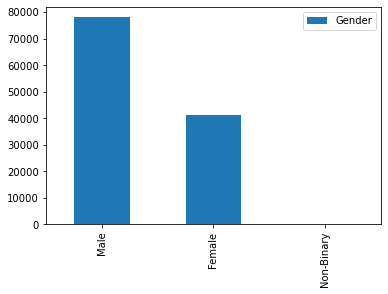

In [223]:
gcounts.plot(kind='bar')

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C36183C310>],
      dtype=object)

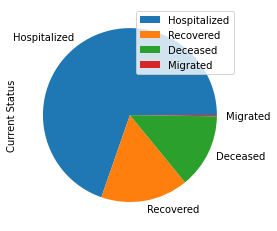

In [224]:
# Individual Current Status
gcounts=pd.DataFrame(individual_data['Current Status'].value_counts())
gcounts.plot(kind='pie',subplots=True)

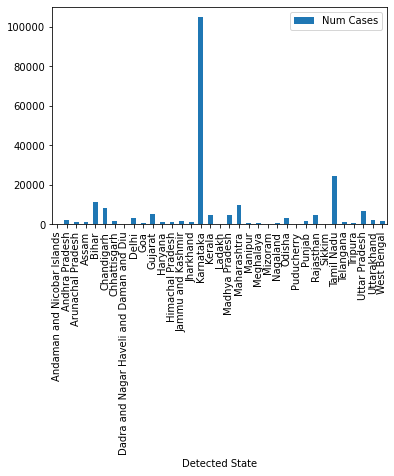

In [225]:
# Group the data by state and find the individual counts for each state
gcounts=pd.DataFrame(individual_data.groupby('Detected State')['Num Cases'].agg(len))
gcounts.plot(kind='bar')

In [226]:
# Top 5 states reporting individual records
gcounts.sort_values(by='Num Cases',ascending=False).head()

,Num Cases
Detected State,
Karnataka,105023.0
Tamil Nadu,24532.0
Bihar,11477.0
Maharashtra,9792.0
Chandigarh,8309.0


## Complete Data

We just worked on individual data but this does not provide us the clear picture lets work on complete data.

### Extact Count per Date

In [227]:
import datetime

In [228]:
date_grop=data.groupby('Date Announced')

In [229]:
# Let's check for a date 
jh=date_grop.get_group('2020-09-20 0:00:00')

Based on data dictionary:

- If the value is == 1 : The row indicates an individual record (age and gender info are subject to state bulletin releases).
- If the value != 1 (greater than or less than 1) : The row indicates a district level record.
- If the value > 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added without district details as state bulletin did not have district details at the point of data entry.
- If the value < 0 and (detecteddistrict == '' or detecteddistrict == 'Unknown') : The row added to adjust a previously added bulk entry as stated above
- If the value < 0 and (detecteddistrict != '' and detecteddistrict != 'Unknown') : The row added due to state bulletins providing a reduced count for that district/day/category combination.
- If the value == 0 : Ingore the record. This would've been an entry made and ignored later due to clarifications from state bulletins.

In [230]:
# We created a test count function that would give us clear idea about the data
def getCounts_test(data):
    ind_count=len(data[data['Num Cases']==1])
    dist_lvl_cnt=data[(data['Num Cases']>0) & ((data['Detected District'].isna()) |
    (data['Detected District']=='Unassigned') | (data['Detected District']=='Unknown')
                                              )]['Num Cases'].sum()
    neg_cnt=data[(data['Num Cases']<0) & ((data['Detected District'].isna()) |
    (data['Detected District']=='Unassigned') | (data['Detected District']=='Unknown')
    )]['Num Cases'].sum()
    empty=len(data[data['Num Cases']==0])
    return ind_count,dist_lvl_cnt,neg_cnt,empty

In [231]:
getCounts_test(jh)

(180, 13444.0, 0.0, 0)

In [232]:
jh['Num Cases'].sum()

181480.0

In [233]:
jh[(jh['Num Cases']<0) & ((jh['Detected District'].isna()) | 
    (jh['Detected District']=='Unassigned') | (jh['Detected District']=='Unknown'))]

,Patient Number,State Patient Number,Date Announced,Age Bracket,Gender,Detected City,Detected District,Detected State,State code,Current Status,Notes,Status Change Date,Source_1,Num Cases,Entry_ID


In [234]:
cday=pd.DataFrame(jh[['Num Cases','Current Status']].groupby('Current Status').agg('sum'))

In [235]:
cday

,Num Cases
Current Status,
Deceased,1135.0
Hospitalized,87395.0
Migrated_Other,24.0
Recovered,92926.0


In [236]:
cday.loc['Deceased'][0]

1135.0

Thus, we have single day count.

### Per Day Count

In [237]:
complete_data={'Date':[],'Deceased':[],'Migrated_Other':[],'Hospitalized':[],'Recovered':[]}
for date in date_grop.groups:
    cd_grp=date_grop.get_group(date)
    counts=pd.DataFrame(cd_grp[['Num Cases','Current Status']].groupby('Current Status').agg('sum'))
    complete_data['Date'].append(date.strftime('%d/%m/%Y'))
    try:
        complete_data['Deceased'].append(counts.loc['Deceased'][0])
    except KeyError: # If keyerror occurs then append 0 for the category
        complete_data['Deceased'].append(0)
    
    try:
        complete_data['Migrated_Other'].append(counts.loc['Migrated_Other'][0])
    except KeyError:
        complete_data['Migrated_Other'].append(0)
    
    try:
        complete_data['Hospitalized'].append(counts.loc['Hospitalized'][0])
    except KeyError:
        complete_data['Hospitalized'].append(0)
       
    try:
        complete_data['Recovered'].append(counts.loc['Recovered'][0])
    except KeyError:
        complete_data['Recovered'].append(0)
        
cdata=pd.DataFrame(complete_data)   

In [240]:
orig=pd.read_csv('https://api.covid19india.org/csv/latest/case_time_series.csv')

In [244]:
latest5=[]
for i in list(pd.to_datetime(cdata.Date,yearfirst=True).sort_values()[-10:]):
    latest5.append(str(i).split(' ')[0])

In [246]:
latest5=[]
for i in list(pd.to_datetime(cdata.Date,yearfirst=True).sort_values()[-5:]):
    latest5.append(str(i).split(' ')[0])
verify=[]
for date in cdata.Date:
    if str(pd.to_datetime(date,yearfirst=True)).split(' ')[0] in latest5:
        verify.append(True)
    else:
        verify.append(False)
cdata[verify]

,Date,Deceased,Migrated_Other,Hospitalized,Recovered
258,12/11/2020,544.0,17.0,44584.0,49354.0
288,12/12/2020,391.0,14.0,30354.0,33087.0
289,13/12/2020,338.0,8.0,27336.0,30640.0
290,14/12/2020,354.0,17.0,21941.0,34421.0
291,15/12/2020,0.0,0.0,9.0,25.0


In [248]:
orig.tail()

,Date,Date_YMD,Daily Confirmed,Total Confirmed,Daily Recovered,Total Recovered,Daily Deceased,Total Deceased
315,10 December,2020-12-10,29411,9796989,37707,9290133,411,141631
316,11 December,2020-12-11,29961,9826950,33492,9323625,442,142073
317,12 December,2020-12-12,30354,9857304,33087,9356712,391,142464
318,13 December,2020-12-13,27336,9884640,30640,9387352,338,142802
319,14 December,2020-12-14,21941,9906581,34421,9421773,354,143156


In [249]:
# Checking total counts:
print('Deceased: ',cdata.Deceased.sum())
print('Migrated_Other: ',cdata.Migrated_Other.sum())
print('Hospitalized: ',cdata.Hospitalized.sum())
print('Recovered: ',cdata.Recovered.sum())

Deceased:  142911.0
Migrated_Other:  2564.0
Hospitalized:  9906439.0
Recovered:  9415660.0


In [250]:
wdata=cdata[['Deceased','Migrated_Other','Hospitalized','Recovered']]

In [251]:
wdata.index=pd.to_datetime(cdata.Date,format='%d/%m/%Y')

In [252]:
wdata=wdata.resample('W')

In [253]:
wdata=wdata.agg(sum)

In [254]:
# Weekly counts of data
wdata

,Deceased,Migrated_Other,Hospitalized,Recovered
Date,,,,
2020-02-02,0.0,0.0,0.0,2.0
2020-02-09,0.0,0.0,0.0,1.0
2020-02-16,0.0,0.0,0.0,0.0
2020-02-23,0.0,0.0,0.0,0.0
2020-03-01,0.0,0.0,0.0,0.0
2020-03-08,0.0,0.0,8.0,28.0
2020-03-15,3.0,3.0,45.0,25.0
2020-03-22,6.0,0.0,247.0,37.0
2020-03-29,12.0,0.0,647.0,77.0


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C322830070>,
      dtype=object)

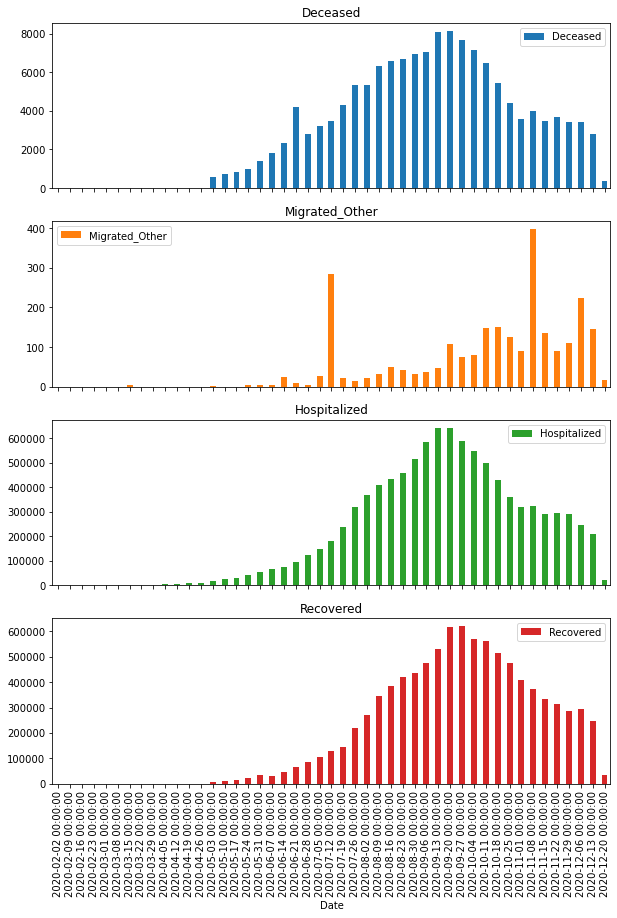

In [262]:

wdata.plot(kind='bar',subplots=True,figsize=(10,14))

In [255]:
# Monthly Rise
mdata=cdata[['Deceased','Migrated_Other','Hospitalized','Recovered']]
mdata.index=pd.to_datetime(cdata.Date,format='%d/%m/%Y')
mdata=mdata.resample('M').agg(sum)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001C360334190>,
      dtype=object)

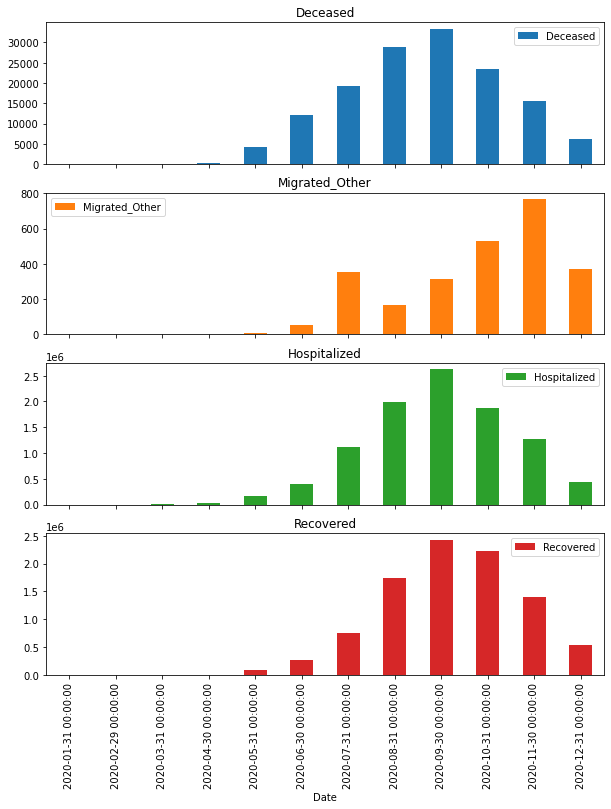

In [256]:
mdata.plot(kind='bar',subplots=True,figsize=(10,12))

### Uses of this data:

- Data can be used for daily, weekly and monthly forecasting of data.
- Data can be used for visualization as well statewise and districtwise rise daily.
- Forecasting can be done at country level and state level as well.